In [2]:
from math import gamma

import scipy
import numpy as np
import scipy.constants as constants
import math
import matplotlib.pyplot as plt

m = 4e-13
temp = 273
K = .0002
r = 2.7e-6
eta = .36e-3
rho_f = 789

times = np.logspace(-8, 2, 60)
zeros = np.zeros(len(times))

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots_ = compute_roots(m, K, r, eta, rho_f)


In [3]:
def hydro_msd(t, roots):
    return 2*constants.k*temp*c_inverse_form(t, roots)

# NEW AND CORRECTED CODE

def a_inverse_form(t, roots):
    return np.real((1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))


def experfc_inverse_form(t, tau, roots):
    return np.real((1/m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots_)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots_) + ensemble_r_term(t1,t2, m, K, roots_)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

stationairy = hydro_msd(times, roots_)

def full_hydro_with_history(t1, t2, m, K, radius, eta, rho_f, x0, v0, u_vector, v_g):
    v_gomez = v_g*(m/(6*math.pi*radius*eta))
    return np.real(x_t1_x_t2_u(t1, t1, m, K, radius, eta, rho_f, x0, v0, u_vector, v_gomez) + x_t1_x_t2_u(t2, t2, m, K, radius, eta, rho_f, x0, v0, u_vector, v_gomez) - 2 * x_t1_x_t2_u(t1, t2, m, K, radius, eta, rho_f, x0, v0, u_vector, v_gomez))

def x_t1_x_t2_u(t1, t2, m, K, radius, eta, rho_f, x0, v0, u_vector, v_gomez):
    return e_and_f_u(t1, m, radius, rho_f, eta, x0, v0, roots_, u_vector, v_gomez)*e_and_f_u(t2, m, radius, rho_f, eta, x0, v0, roots_, u_vector, v_gomez) + ensemble_r_term(t1,t2, m, K, roots_)

def e_and_f_u(t, mass, radius, rho, eta, x0, v0, roots, u_vector, v_gomez):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho*eta)
    print(u_term(t, u_vector, roots, v_gomez))
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) + z*v0*s_minus_half_b_inverse_form(t, roots) + u_term(t, u_vector, roots, v_gomez)

import numpy as np
from scipy.special import erfi

def u_term(t, u_vector, roots, v_gomez):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]
    u_vector = u_vector #/2000000000000
    ret = 0
    for i in range(len(u_vector)):
        w = v_gomez/5**(i+1)
        # print("w is " + str(w))
        add_u = u_vector[i]*((1/m) * sum(
            (z * scipy.special.erfcx(z * np.sqrt(t))) /
            (np.prod([z - z_j for z_j in roots if z != z_j]))*(z**2+w) for z in roots) + (np.exp(-t*w)*(a*b*c*d - (b*c + (b + c)*d + a*(b + c + d))*w + w**2 + np.sqrt(w)*(a*b*c + a*b*d + a*c*d + b*c*d - (a + b + c + d)*w)*erfi(np.sqrt(w)*np.sqrt(t))))/((a**2+w)*(b**2+w)*(c**2+w)*(d**2+w)))
        ret += add_u
    return ret

In [4]:
def load_mean_u_by_velocity(filename):
    velocity_blocks = []
    current_block = []
    current_velocity = None

    with open(filename, "r") as f:
        for line in f:
            if line.startswith("# velocity"):
                if current_block:
                    velocity_blocks.append((current_velocity, np.array(current_block)))
                    current_block = []
                current_velocity = float(line.split(":")[1])
            else:
                parts = line.strip().split()
                current_block.append((float(parts[0]), float(parts[1])))

        # Add the last block
        if current_block:
            velocity_blocks.append((current_velocity, np.array(current_block)))

    return velocity_blocks
velocity_blocks = load_mean_u_by_velocity(r"..\data\mean_u_by_velocity.txt")

def find_mean_u_at_velocity(v_query, velocity_blocks):
    # Assume evenly spaced bins — use difference between two known centers
    if len(velocity_blocks) < 2:
        raise ValueError("Need at least two bins to determine bin width.")

    bin_width = abs(velocity_blocks[1][0] - velocity_blocks[0][0])

    for v_bin_center, arr in velocity_blocks:
        # print(v_query, v_bin_center)
        if abs(v_query - v_bin_center) < bin_width / 2:
            return arr[:,0]  # shape (13, 2): each row is (mean, std)

    return np.zeros(13)

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\mean_u_by_velocity.txt'

In [8]:
# We need the IC for v(0 as a funtion of x_0)
def v_0_for_x0(x_0, m, radius, eta, roots_):
    ret = x_0 * (1 - m*a_inverse_form())

In [9]:
# Sample from a normal distribution to get the msd for different x0, v0

mu = 0
sigma_v = np.sqrt(constants.k*temp/m)
sigma_x = np.sqrt(constants.k*temp/K)
num_samples = [60]
mean_xs = []
mean_vs = []
avg_nu_sample_msd = []
for num_sample in num_samples:
    initial_conditions_v = np.random.normal(mu, sigma_v, num_sample)
    initial_conditions_x = np.random.normal(mu, sigma_x, num_sample)

    # mean_xs.append(np.mean(initial_conditions_x))
    # mean_vs.append(np.mean(initial_conditions_v))

    results = np.zeros((num_sample, len(times)))
    # results2 = np.zeros((num_sample, len(times)))

    for i in range(num_sample):
        # u_vec = find_mean_u_at_velocity(initial_conditions_v[i], velocity_blocks)
        # print(u_vec)
        results[i, :] = full_hydro_msd(0, times, m, K, r, eta, rho_f, initial_conditions_x[i], initial_conditions_v[i])
        # results2[i, :] = full_hydro_with_history(0, times, m, K, r, eta, rho_f, initial_conditions_x[i], initial_conditions_v[i], u_vec, 10**3)

    averaged_initial_msd = results.mean(axis=0)
    avg_nu_sample_msd.append(averaged_initial_msd)
    # averaged_initial_msd2 = results2.mean(axis=0)

ic_is_sigma = full_hydro_msd(0, times, m, K, r, eta, rho_f,  -np.sqrt(constants.k*temp/K), -np.sqrt(constants.k*temp/m))
zero_ic = full_hydro_msd(0, times, m, K, r, eta, rho_f,  0, 0)


C:\Users\mcthu\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\mcthu\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


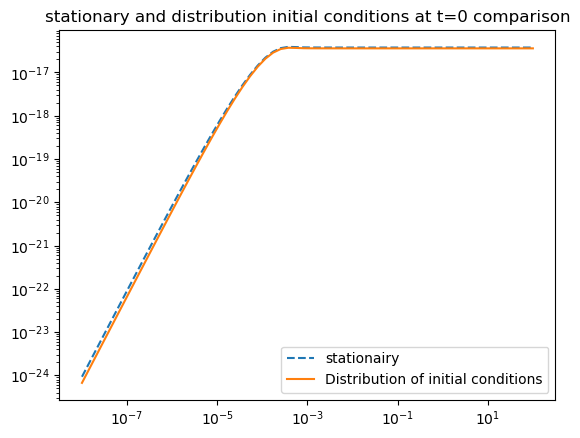

In [10]:

plt.plot(times, stationairy, linestyle = 'dashed', label = "stationairy")
# plt.plot(times, averaged_initial_msd2/1e32, label = "Distribution of initial conditions with History")
plt.plot(times, avg_nu_sample_msd[0], label = "Distribution of initial conditions")
# plt.plot(times, ic_is_sigma, label = "initial x0 = kT/K, intial v0 = kT/m")
# plt.plot(times, zero_ic, label = "initial x0 = 0, intial v0 = 0")
plt.title("stationary and distribution initial conditions at t=0 comparison")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

# plt.plot(times, stationairy, linestyle = 'dashed', label = "stationairy")
# plt.plot(times, averaged_initial_msd, label = "Distribution of initial conditions")
# plt.title("Comparison with initial conditions = sigma and initial conditions at t=0")
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

diffs = []
for i in range(1, len(num_samples)):
    diff = (stationairy - avg_nu_sample_msd[i])/stationairy
    diffs.append(diff)
    plt.plot(times, diff, label = f"diff num={num_samples[i]}")
    plt.legend()
    plt.xscale('log')
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
# plt.yscale('log')



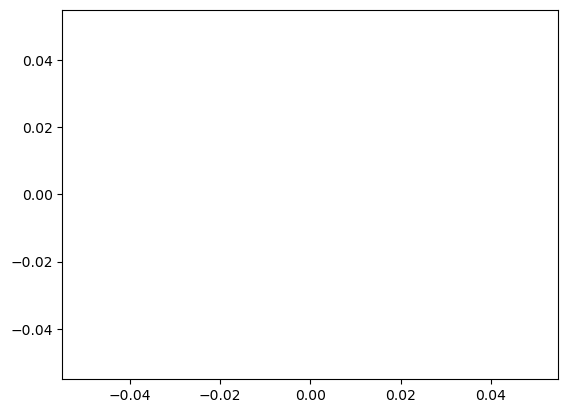

In [11]:

areas = [np.trapz(diff) for diff in diffs]
plt.plot(areas)


In [12]:
t1s = [0, 1e-5, 1e-3]
t1_comparisons = []
num_samples = 1000

for t1 in t1s:
    t1 = np.full(len(times), t1)
    t2 = t1 + times

    for i in range(num_samples):
      results[i, :] = full_hydro_msd(t1, t2, m, K, r, eta, rho_f, initial_conditions_x[i], initial_conditions_v[i])
    averaged_initial_msd = results.mean(axis=0)
    t1_comparisons.append(averaged_initial_msd)

for i in range(len(t1s)):
    plt.plot(times, t1_comparisons[i], label = f"t1={t1s[i]}")
plt.plot(times, stationairy, linestyle="dashed", label = "stationairy")
plt.xscale('log')
plt.yscale('log')
plt.legend()

IndexError: index 60 is out of bounds for axis 0 with size 60

C:\Users\mct2723\AppData\Local\Temp\ipykernel_13836\2076590384.py:43: RuntimeWarning: invalid value encountered in sqrt
  (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
C:\Users\mct2723\AppData\Local\Temp\ipykernel_13836\2076590384.py:43: RuntimeWarning: invalid value encountered in multiply
  (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /


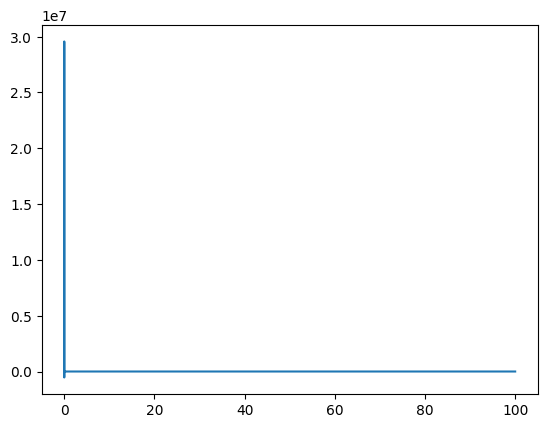

C:\Users\mct2723\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\mct2723\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


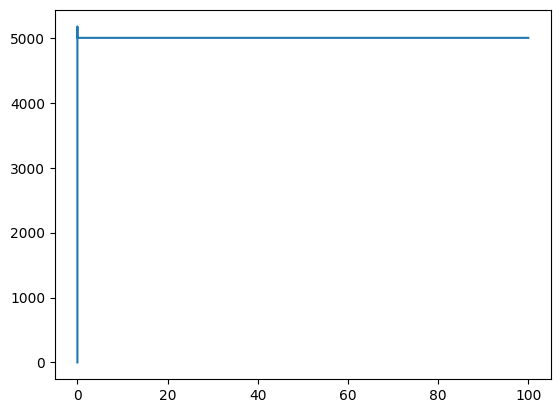

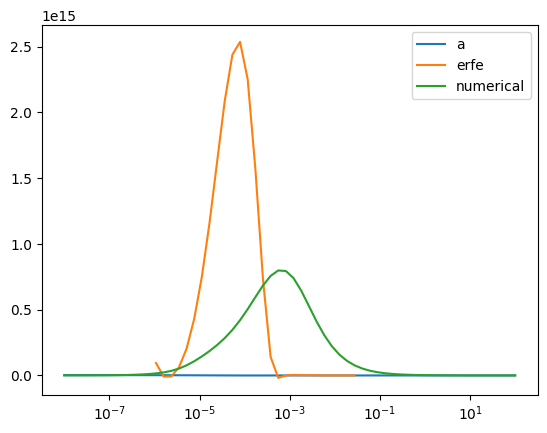

In [5]:
from scipy.interpolate import interp1d
# from scipy.integrate import cumtrapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, pi, exp, erfc
# GRAPH C
a_help = a_inverse_form(times, roots_)
c_help = c_inverse_form(times, roots_)
b_help = b_inverse_form(times, roots_)
s_minus = s_minus_half_b_inverse_form(times, roots_)
s_plus = s_half_b_inverse_form(times, roots_)
erfe = experfc_inverse_form(times, .0001, roots_)
tau = 1e-6


# Laplace-domain function F(s, tau)
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = m*(roots_[0] + sqrt(s)) * (roots_[1] + sqrt(s)) * (roots_[2] + sqrt(s)) * (roots_[3] + sqrt(s))
    inv = 2/sqrt(-tau) - 2 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau)
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))

numerical_erfe = [f(time, tau) for time in times]

b_min_e = b_inverse_form(times, roots_)/np.sqrt(tau) - np.sqrt(np.pi)*experfc_inverse_form(times, tau, roots_)

# Create interpolation function
a_int_b = interp1d(times, a_help, kind='cubic')  # Cubic for smoothness
b_int_c = interp1d(times, b_help, kind='cubic')
sm_int_sp = interp1d(times, s_plus, kind='cubic')

# Compute the integral using cumtrapz
# Evaluate a_int_b at times for integration
a_help_interp = a_int_b(times)
# integral_a = cumtrapz(a_help_interp, times, initial=0)

b_help_interp = b_int_c(times)
# integral_b = cumtrapz(b_help_interp, times, initial=0)

s_plus_interp = sm_int_sp(times)
# integral_sp = cumtrapz(s_plus_interp, times, initial=0)

# plt.plot(times, a_help, label = "a")
plt.plot(times, b_help, label = "b")
# plt.plot(times, integral_a, label = "integral of a")
#
plt.show()
plt.plot(times, c_help, label = "c")
# plt.plot(times, integral_b, label = "integral of b")
plt.show()
plt.plot(times, a_help, label = "a")
plt.plot(times, b_min_e*100000, label = "erfe")
plt.plot(times, numerical_erfe, label = "numerical")
# plt.plot(times, integral_sp, label = "integral s+")
# plt.plot(times, s_plus, label = "s+")
plt.xscale('log')
# plt.yscale('log')
# plt.xlim(left=100)
# plt.ylim(bottom = 0, top=0.01)
plt.legend()

get a s


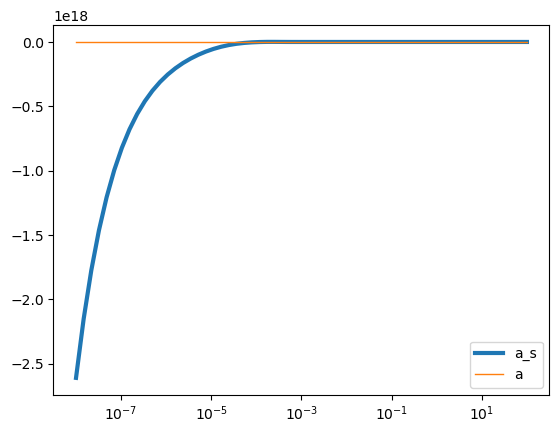

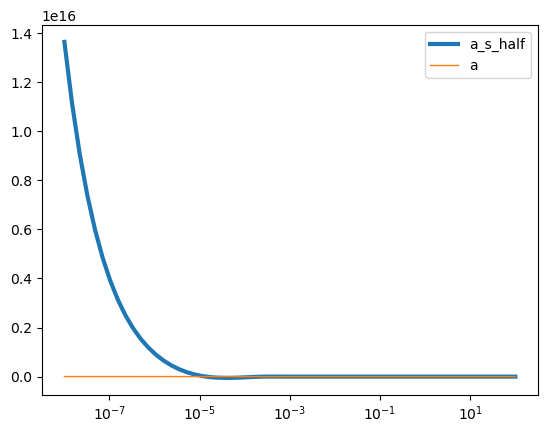

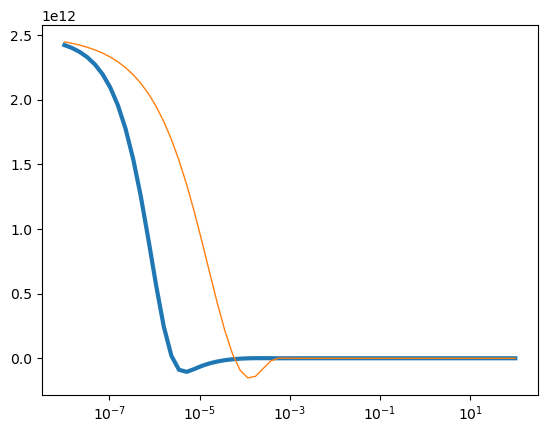

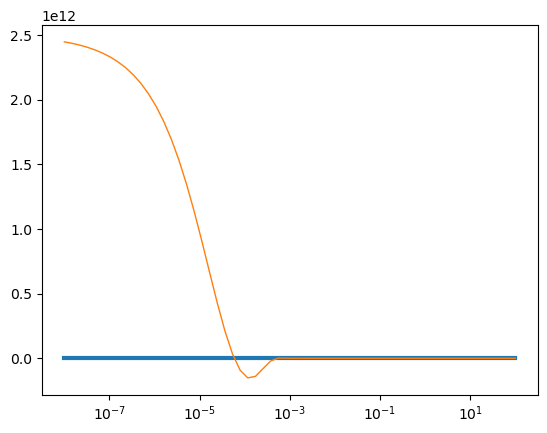

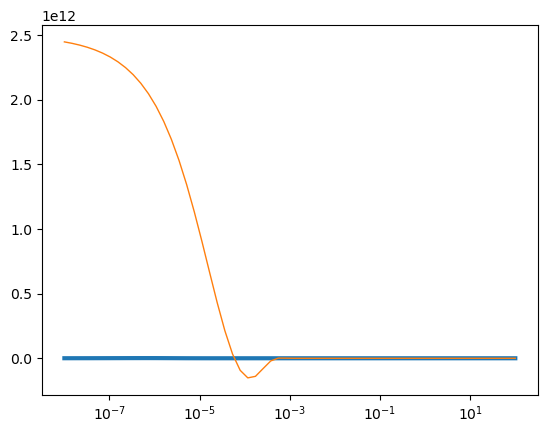

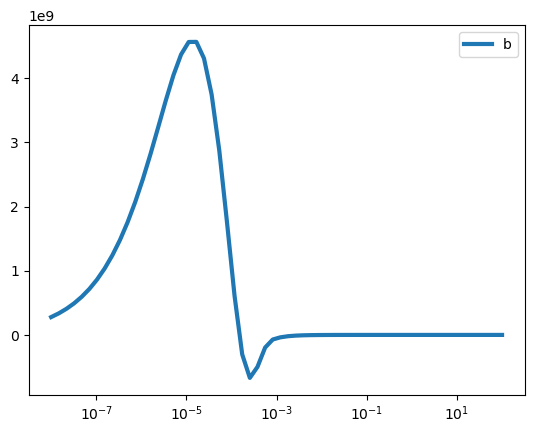

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, invertlaplace

# THIS IS WHERE WE ESTIMATE <R(t1)v(t2)>

# THIS IS FOR THE 2nd TERM
# Set desired precision
mp.dps = 15  # or however many digits of precision you want

# Your Laplace-domain function
def a_s(s):
    D = m * (roots_[0] + mp.sqrt(s)) * (roots_[1] + mp.sqrt(s)) * \
        (roots_[2] + mp.sqrt(s)) * (roots_[3] + mp.sqrt(s))
    num = s**2
    return num / D

# Scalar inverse Laplace
def get_a_s_scalar(t):
    return float(mp.re(invertlaplace(a_s, t, method='talbot')))

# Vectorized version for arrays
get_a_s = np.vectorize(get_a_s_scalar)

print("get a s")

plt.plot(times, get_a_s(times), linewidth=3, label="a_s")
plt.plot(times, a_help, linewidth=1, label = "a")
plt.xscale('log')
plt.legend()
# plt.yscale('log')
plt.show()

# THIS IS FOR THE 8th TERM
def a_s_half(s):
    D = m * (roots_[0] + mp.sqrt(s)) * (roots_[1] + mp.sqrt(s)) * \
        (roots_[2] + mp.sqrt(s)) * (roots_[3] + mp.sqrt(s))
    num = s**(3/2)
    return num / D

# Scalar inverse Laplace
def get_a_s_half_scalar(t):
    return float(mp.re(invertlaplace(a_s_half, t, method='talbot')))

# Vectorized version for arrays
get_a_s_half = np.vectorize(get_a_s_half_scalar)

plt.plot(times, get_a_s_half(times), linewidth=3, label="a_s_half")
plt.plot(times, a_help, linewidth=1, label = "a")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()
# THIS IS FOR THE FIRST TERM

# Your Laplace-domain function
def a_1(s, a):
    D = m * (roots_[0] + mp.sqrt(s)) * (roots_[1] + mp.sqrt(s)) * \
        (roots_[2] + mp.sqrt(s)) * (roots_[3] + mp.sqrt(s))
    num = s**2/(s+a)
    return num / D

# Scalar inverse Laplace
def get_a_s1(t, a):
    def a_1_call(s):
        return a_1(s,a)
    return float(mp.re(invertlaplace(a_1_call, t, method='talbot')))

# Vectorized version for arrays
get_a_1 = np.vectorize(get_a_s1)
s_prime = 1e6

# Term 1 easier part

# Your Laplace-domain function
def a_1_prime(s, a):
    D = m * (roots_[0] + mp.sqrt(s)) * (roots_[1] + mp.sqrt(s)) * \
        (roots_[2] + mp.sqrt(s)) * (roots_[3] + mp.sqrt(s))
    num = s/(s+a)
    return num / D

# Scalar inverse Laplace
def get_a_1_prime(t, a):
    def a_1_prime_call(s):
        return a_1_prime(s,a)
    return float(mp.re(invertlaplace(a_1_prime_call, t, method='talbot')))

# Vectorized version for arrays
get_a_1_prime = np.vectorize(get_a_1_prime)
s_prime = 1e6


plt.plot(times, get_a_1(times, s_prime), linewidth=3, label="a_1")
plt.plot(times, a_help, linewidth=1, label = "a")
plt.xscale('log')
# plt.yscale('log')
plt.show()

plt.plot(times, get_a_1_prime(times, s_prime), linewidth=3, label="a_1 easy")
plt.plot(times, a_help, linewidth=1, label = "a")
plt.xscale('log')
# plt.yscale('log')
plt.show()


# Term 7

# Your Laplace-domain function
def a_2(s, a):
    D = m * (roots_[0] + mp.sqrt(s)) * (roots_[1] + mp.sqrt(s)) * \
        (roots_[2] + mp.sqrt(s)) * (roots_[3] + mp.sqrt(s))
    num = s**(3/2)/(s+a)
    return num / D

# Scalar inverse Laplace
def get_a_2(t, a):
    def a_2_call(s):
        return a_2(s,a)
    return float(mp.re(invertlaplace(a_2_call, t, method='talbot')))

# Vectorized version for arrays
get_a_2 = np.vectorize(get_a_2)
s_prime = 1e6

plt.plot(times, get_a_2(times, s_prime), linewidth=3, label="a_1")
plt.plot(times, a_help, linewidth=1, label = "a")
plt.xscale('log')
# plt.yscale('log')
plt.show()

plt.plot(times, s_half_b_inverse_form(times, roots_), linewidth=3, label="b")
plt.legend()
plt.xscale('log')
plt.show()


[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  7  4  3  6]
[ 3  4  7  0  1  2  5  8  9 10 11  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  7  4  3  6]
[ 3  4  7  0  1  2  5  8  9 10 11  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  7  4  3  6]
[ 3  4  7  0  1  2  5  8  9 10 11  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5  8  9 10 11  4  3  7  6]
[ 0  1  2  5

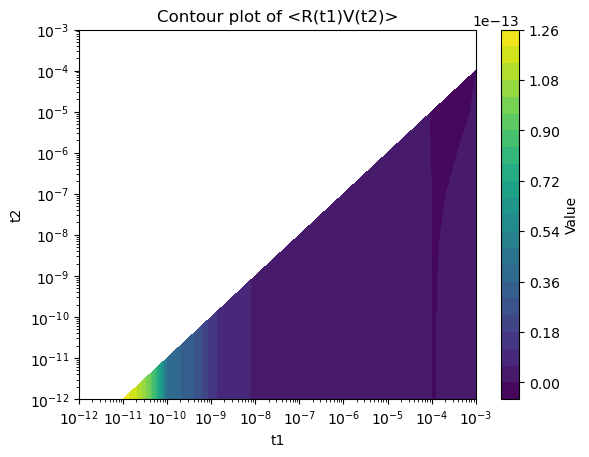

In [75]:
# SOLVE FOR <R(t1)V(t2)> the v(0) = 0
z = 6*r**2*np.pi*np.sqrt(rho_f*eta)

def r_t1_v_t2(t1, t2):
    # MsA(s)/(s + s') + MsA(s')/(s+s')
    # first we do s' then s, vice versa

    term1 = m * get_a_s(np.abs(t1-t2))
    #
    if np.any(t2>t1):
        print("this function is not meant to be used in this way - need to do more work")
        # There is also a dirac delta in here

    term2 = m**2 * get_a_s(t1) * a_inverse_form(t2, roots_)

    term3 = 0# m*K* a_inverse_form(t1, roots_) * b_inverse_form(t2, roots_)

    term4 = 6*np.pi*r*eta * a_inverse_form(np.abs(t1-t2), roots_)

    term5 = 6*np.pi*r*eta *m * a_inverse_form(t1, roots_) *a_inverse_form(t2, roots_)

    term6 = 0#K * 6*np.pi*r*eta *b_inverse_form(t1, roots_) *b_inverse_form(t2, roots_)

    term7 = z * get_a_s_half(np.abs(t1-t2)) + z*(1/(np.pi*t1)**(1/2))*a_inverse_form(t2, roots_)

    term8 = m*z* get_a_s_half(t1) * a_inverse_form(t2, roots_)

    term9 = 0# K*z*s_half_b_inverse_form(t1, roots_) * a_inverse_form(t2, roots_)

    term10 = 0#K*b_inverse_form(t2, roots_) + K*b_inverse_form(np.abs(t1-t2), roots_)

    term11 = 0#m*K*b_inverse_form(t1, roots_) * a_inverse_form(t2, roots_)

    term12 = 0#K**2 *c_inverse_form(t1, roots_) * b_inverse_form(t2, roots_)
    indicies = np.argsort([term1, term2, term3, term4, term5, term6, term7, term8, term9, term10, term11, term12])
    print(indicies)
    return constants.k * temp * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12)

# OK we have this all coded up... Lets see what it looks for a grid of values where t1>t2, t2<0...
t1s = np.logspace(-12, -3, 10)
t2s = np.logspace(-12, -3, 10)

values = np.zeros((len(t2s), len(t1s)))  # rows: t2, cols: t1

for i, t2 in enumerate(t2s):
    for j, t1 in enumerate(t1s):
        if t1 > t2:
            values[i, j] = r_t1_v_t2(t1, t2)
        else:
            values[i, j] = np.nan  # or 0, depending on how you want to treat t1 <= t2

# Now create meshgrid for plotting
XX, YY = np.meshgrid(t1s, t2s)

contour = plt.contourf(XX, YY, values, levels=20)
plt.xscale('log')
plt.yscale('log')  # Optional
plt.xlabel("t1")
plt.ylabel("t2")
plt.title("Contour plot of <R(t1)V(t2)>")
plt.colorbar(label="Value")
plt.show()


[2.49948349e+12 2.49709465e+12 2.48363739e+12 2.40729445e+12
 1.97045637e+12]


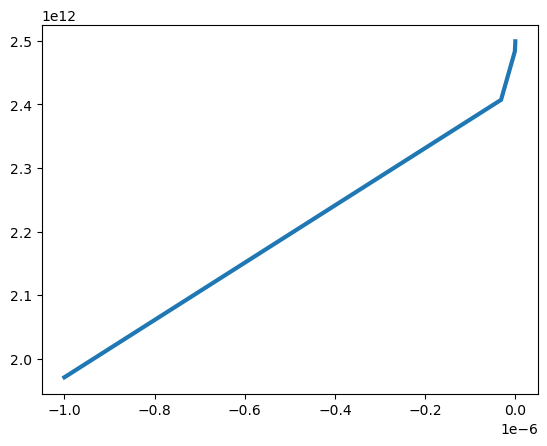

In [48]:
a_neg = a_inverse_form(-t2s, roots_)
print(a_neg)
plt.plot(t2s, a_neg, linewidth=3, label="a_neg")
# plt.xscale('log')
plt.show()